In [3]:
import numpy as np 
import scipy as sp 
import matplotlib.pyplot as plt
import pandas as pd
from osc_toolkit import oscillation
from models import *
from functools import partial
from ddeint import ddeint

In [173]:
class delayed_oscillation(oscillation):
    def __init__(self, model, delay, params, consts, init_cond, calc_all):
        super().__init__(model, params, consts, init_cond, calc_all)
        self.__delay = delay
        
    @property
    def info(self):
        print(
            f'Time-delayed model. The model includes {len(self._oscillation__params)} parameters and {len(self._oscillation__consts)} constants. The species are {self._oscillation__species}. Initial condition: {self._oscillation__init_cond}')
        print(f'Additional information: {self._oscillation__info}')

    def set_delay(self, delay):
        self.__delay = delay
    
    def simulate(self, t=10, t_eval='default', init_cond=None):
        params_pass = np.hstack((self._oscillation__params, self._oscillation__consts))
        model_partial = partial(self._oscillation__model, params=params_pass)
        td1, td2 = self.__delay
        t_span = (0, t)
        if type(t_eval) == str:
            t_eval = np.linspace(0, t, int(40*t))

        #Default: initial condition is passed by the property. It can also be passed by external input

        if isinstance(init_cond, (np.ndarray, list, tuple)):
            y0 = init_cond
        else:
            y0 = self._oscillation__init_cond
        
        history = lambda t: np.array(y0)

        sol = ddeint(model_partial, history, t_eval, fargs=(td1,td2))

        return (sol, t_eval)
    
    def plot(self, t=10, exp=False):
        i = 0
        if exp == True:
            y0 = [np.array(self._oscillation__exp_data.iloc[0, 1]), np.array(self._oscillation__exp_data.iloc[0, 3])]
            sol, t = self.simulate(t=self._oscillation__exp_data.iloc[-1, 0], init_cond=y0)
            c = self._oscillation__calc_all(sol, self._oscillation__consts, self._oscillation__params)
            fig, axes = plt.subplots(2, 1, figsize=(5, 5))
            for ax in axes:
                ax.plot(
                    self._oscillation__exp_data.iloc[:, 2*i], self._oscillation__exp_data.iloc[:, 2*i+1], label=f'exp-{self._oscillation__species[i]}')
                ax.plot(t, c[i], label=self._oscillation__species[i])
                ax.set_xlabel('Normalized Time')
                ax.set_ylabel('Normalized Concentration')
                ax.legend(loc="upper right")
                i += 1
                plt.tight_layout()
        else:
            sol, t = self.simulate(t)
            c = self._oscillation__calc_all(sol, self._oscillation__consts, self._oscillation__params)
            fig, axes = plt.subplots(2, 2, figsize=(7, 5))
            for ax, y in zip(axes.flatten(), c):
                ax.plot(t, y, label=self._oscillation__species[i])
                ax.set_xlabel('Normalized Time')
                ax.set_ylabel('Normalized Concentration')
                ax.legend(loc="upper right")
                i += 1
                plt.tight_layout()

        return fig, axes

In [205]:
files = ['Data_sets/1_expB_osc_NatChem_MH.csv',
         'Data_sets/3b_expB_osc_NatChem_MH.csv',
         'Data_sets/4_expB_osc_NatChem_MH.csv']

df_list = [pd.read_csv(file) for file in files]

exp_data = pd.concat(df_list, axis=1)

exp_data.columns = ['t1', 'c1', 't3b', 'c3b', 't4', 'c4']

cut_off, CMC_3b = 112, 0.52
tau = 0.24
C_A2tol = exp_data.loc[0, 'c1'] + exp_data.loc[0, 'c4'] / 2

exp_data = exp_data.head(cut_off)
exp_data[['c1', 'c4']] /= C_A2tol
exp_data['c3b'] /= CMC_3b

for s in ['t1', 't3b', 't4']:
    exp_data = exp_data.drop_duplicates(subset=s)
    exp_data[s] /= tau

print(C_A2tol)


df_MHNatChem = exp_data.clip(lower=0)
df_MHNatChem.loc[0, 't3b'] = 0
df_MHNatChem.loc[0, 't4'] = 0

3.1426606946408935


In [175]:
def delayed_approx_model_FTC(vars, t, td1, td2, params):
    #td1 is shorter delay, td2 is longer delay
    alpha, beta, theta, phi, k, lam, m = params
    cA2, cS = vars(t)
    cA2_td1, cS_td1 = vars(t - td1)
    cA2_td2, cS_td2 = vars(t - td2)

    cT1 = cS_td1**m
    cT2 = cS_td2**m

    dcA2dt = (2 * (1 - cA2) - lam * (cS + cS**m))**2 / ((2 * (1 - cA2) - lam * (cS + cS**m))**2 + k * cT2**2) - alpha * cA2 * cT1 - theta * cA2
    dcSdt = alpha/lam * cA2 * cT1 - beta * cT1 * cS + theta/lam * cA2 - phi * cS
    
    return np.array((dcA2dt, dcSdt))

def calc_all_delayed_approx_model_FTC(sol, consts, *params):
    lam, m = consts
    cA2 = sol[:, 0]
    cS = sol[:, 1]
    cM = cS ** m
    cA = 2 * (1 - cA2) - lam * (cS + cM)
    cO = 1 / (2 * (1 - cA2) - lam * (cS + cM)) ** 2
    return np.array([cA2, cS + cM, cA, cO])

(<Figure size 700x500 with 4 Axes>,
 array([[<Axes: xlabel='Normalized Time', ylabel='Normalized Concentration'>,
         <Axes: xlabel='Normalized Time', ylabel='Normalized Concentration'>],
        [<Axes: xlabel='Normalized Time', ylabel='Normalized Concentration'>,
         <Axes: xlabel='Normalized Time', ylabel='Normalized Concentration'>]],
       dtype=object))

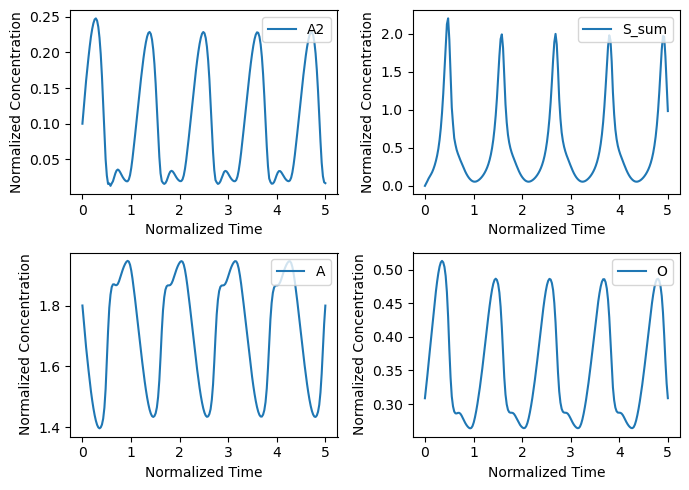

In [206]:
params = np.array([60, 5, 2, 11, 80])
consts = [0.17, 2]
init_cond = [0.1, 0]
delayed_model = delayed_oscillation(delayed_approx_model_FTC, delay=1, params=params, consts=consts, init_cond=init_cond, calc_all=calc_all_delayed_approx_model_FTC)
delayed_model.set_delay((0.1, 0.4))
delayed_model.plot(t=5)

In [202]:
delayed_model.add_exp_data(df_MHNatChem)

The species are ['A2', 'S_sum', 'A', 'O']. Please check if the data is in the same order and correct format (time, concentration).


(<Figure size 500x500 with 2 Axes>,
 array([<Axes: xlabel='Normalized Time', ylabel='Normalized Concentration'>,
        <Axes: xlabel='Normalized Time', ylabel='Normalized Concentration'>],
       dtype=object))

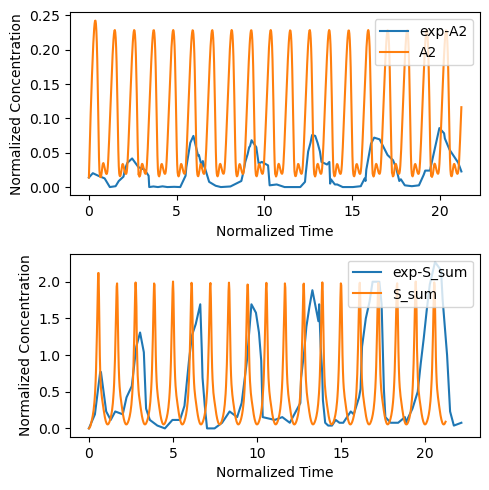

In [203]:
delayed_model.plot(exp=True)

In [204]:
delayed_model.interactive_plot(exp=True, ran=60)

interactive(children=(FloatSlider(value=60.0, description='alpha', max=120.0, step=0.05), FloatSlider(value=5.…

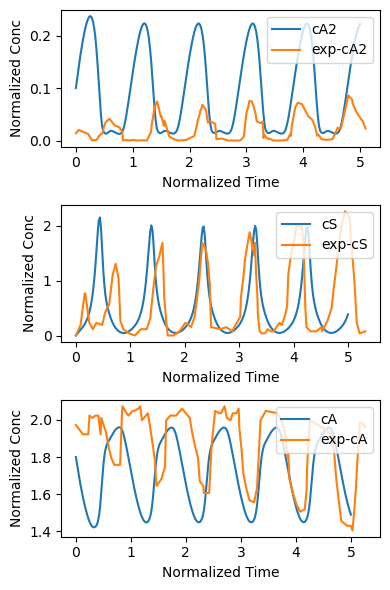

In [135]:
sol, t = delayed_model.simulate(t=5)
cA2 = sol[:, 0]
cS = sol[:, 1]
cA = 2 * (1 - cA2) - consts[0] * (cS + cS**consts[1])
fig, ax = plt.subplots(3, 1, figsize=(4, 6))

ax[0].plot(t, cA2, label='cA2')
ax[0].plot(df_MHNatChem['t1'], df_MHNatChem['c1'], label='exp-cA2')
ax[0].set_xlabel('Normalized Time')
ax[0].set_ylabel('Normalized Conc')
ax[0].legend(loc='upper right')

ax[1].plot(t, cS + cS**consts[1], label='cS')
ax[1].plot(df_MHNatChem['t3b'], df_MHNatChem['c3b'], label='exp-cS')
ax[1].set_xlabel('Normalized Time')
ax[1].set_ylabel('Normalized Conc')
ax[1].legend(loc='upper right')

ax[2].plot(t, cA, label='cA')
ax[2].plot(df_MHNatChem['t4'], df_MHNatChem['c4'], label='exp-cA')
ax[2].set_xlabel('Normalized Time')
ax[2].set_ylabel('Normalized Conc')
ax[2].legend(loc='upper right')

plt.tight_layout()